In [2]:
!git clone https://github.com/hodakamori/torch-tutorial

Cloning into 'torch-tutorial'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 90 (delta 34), reused 75 (delta 22), pack-reused 0
Receiving objects: 100% (90/90), 17.99 MiB | 14.37 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [3]:
!cp torch-tutorial/diffusion_two_for_one/* .

In [4]:
!pip install graph-transformer-pytorch rdkit MDAnalysis diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 259.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.1/819.1 kB 41.3 MB/s eta 0:00:00


In [5]:
import torch
from torch.utils.data import DataLoader
from dataset import CGCoordsDataset
from model import Net

In [6]:
device = torch.device("cuda")
topology_path = "./ala2_cg.pdb"
traj_path = "./ala2_cg.xtc"
dataset = CGCoordsDataset(topology_path, traj_path)
print(len(dataset))

20000


/usr/local/lib/python3.10/dist-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/usr/local/lib/python3.10/dist-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: X
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [7]:
import torch
from graph_transformer_pytorch import GraphTransformer
import torch.nn as nn


class Net(nn.Module):
    def __init__(self, num_atoms, num_node_features, device=torch.device("cuda")):
        super().__init__()
        self.gt = GraphTransformer(
            dim=num_node_features + 1,
            depth=6,
            edge_dim=3,
            with_feedforwards=True,
            gated_residual=True,
        )
        self.linear = nn.Linear(num_node_features + 1, 1)
        self.atom_embedding = nn.Embedding(num_atoms, num_node_features)
        self.device = device

    def nodes_embedding(self, indices, noise_levels):
        noise_levels = noise_levels.unsqueeze(1).unsqueeze(2).expand(indices.shape[0], indices.shape[1], -1)
        encodings = self.atom_embedding(indices)
        embedding = torch.cat((encodings, noise_levels), dim=2)
        return embedding

    def edges_embedding(self, bonds, coordinates):
        num_atoms = coordinates.shape[1]
        edges = torch.zeros(
            (len(coordinates), num_atoms, num_atoms, 3), dtype=torch.float32
        )
        for n in range(len(edges)):
            for bond in bonds:
                i, j = int(bond[0]), int(bond[1])
                edges[n, i, j] = coordinates[n, i] - coordinates[n, j]
                edges[n, j, i] = coordinates[n, j] - coordinates[n, i]
        return edges.to(self.device)

    def forward(self, indices, coordinates, bonds, noise_levels):
        indices = indices.to(self.device)
        coordinates = coordinates.to(self.device)
        coordinates.requires_grad_()
        bonds = bonds.to(self.device)
        nodes = self.nodes_embedding(indices, noise_levels)
        edges = self.edges_embedding(bonds, coordinates)
        mask = torch.ones((nodes.shape[0], nodes.shape[1])).bool().to(self.device)
        nodes, edges = self.gt(nodes, edges, mask=mask)
        nodes, _ = self.gt(nodes, edges, mask=mask)
        energy = self.linear(nodes).sum()
        gradient = torch.autograd.grad(energy, coordinates, create_graph=True)[0]
        return gradient


In [8]:
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
BATCH_SIZE = 1024
MAX_EPOCHS = 30
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
bonds = dataset.bonds
model = Net(num_atoms=5, num_node_features=96)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=MAX_EPOCHS, eta_min=1e-5)
loss_func = torch.nn.MSELoss()

history = []
for epoch in range(MAX_EPOCHS):
    for iter, (indices, coords) in enumerate(dataloader):
        coords = coords.to(device)
        coords.requires_grad_()

        random_values_low = torch.randint(0, (noise_scheduler.num_train_timesteps // 10), (coords.shape[0],), dtype=torch.int)
        random_values_high = torch.randint((noise_scheduler.num_train_timesteps // 10), noise_scheduler.num_train_timesteps, (coords.shape[0],), dtype=torch.int)
        coin_flips = torch.rand(coords.shape[0])
        timesteps = torch.where(coin_flips <= 0.5, random_values_low, random_values_high).to(device)

        noise = torch.randn(coords.shape).to(device)
        noised_coords = noise_scheduler.add_noise(coords, noise, timesteps)
        optimizer.zero_grad()
        noise_pred = model(indices, noised_coords, bonds, noise_levels=timesteps)
        loss = loss_func(noise, noise_pred)
        print(f"{epoch=}, {iter=}, loss={loss.detach().cpu().numpy()}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        history.append(loss.detach().cpu().numpy())
    scheduler.step()
    print(epoch, sum(history) / len(history))

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


epoch=0, iter=0, loss=0.9805660247802734
epoch=0, iter=1, loss=0.9397547841072083
epoch=0, iter=2, loss=0.9717725515365601
epoch=0, iter=3, loss=0.7796306014060974
epoch=0, iter=4, loss=0.697218656539917
epoch=0, iter=5, loss=0.7388548254966736
epoch=0, iter=6, loss=0.7167294025421143
epoch=0, iter=7, loss=0.717808187007904
epoch=0, iter=8, loss=0.7016746401786804
epoch=0, iter=9, loss=0.6885092258453369
epoch=0, iter=10, loss=0.684804379940033
epoch=0, iter=11, loss=0.6845116019248962
epoch=0, iter=12, loss=0.6761225461959839
epoch=0, iter=13, loss=0.674842357635498
epoch=0, iter=14, loss=0.6807205677032471
epoch=0, iter=15, loss=0.6610103249549866
epoch=0, iter=16, loss=0.6706029772758484
epoch=0, iter=17, loss=0.6797767281532288
epoch=0, iter=18, loss=0.671013593673706
epoch=0, iter=19, loss=0.664634108543396
0 0.7340279042720794
epoch=1, iter=0, loss=0.6624739766120911
epoch=1, iter=1, loss=0.6691461801528931
epoch=1, iter=2, loss=0.6791094541549683
epoch=1, iter=3, loss=0.66922599

Text(0, 0.5, 'Loss')

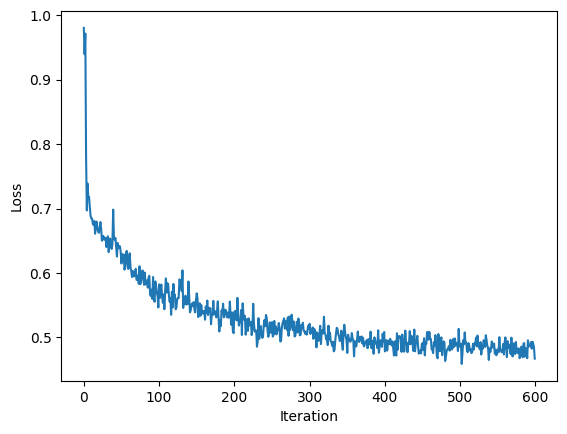

In [10]:
import matplotlib.pyplot as plt
plt.plot(history)
plt.xlabel("Iteration")
plt.ylabel("Loss")

In [11]:
torch.save(model.state_dict(), 'model.pth')
model.load_state_dict(torch.load('model.pth'))
model.eval()

Net(
  (gt): GraphTransformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (fn): Attention(
              (to_q): Linear(in_features=97, out_features=512, bias=True)
              (to_kv): Linear(in_features=97, out_features=1024, bias=True)
              (edges_to_kv): Linear(in_features=3, out_features=512, bias=True)
              (to_out): Linear(in_features=512, out_features=97, bias=True)
            )
            (norm): LayerNorm((97,), eps=1e-05, elementwise_affine=True)
          )
          (1): GatedResidual(
            (proj): Sequential(
              (0): Linear(in_features=291, out_features=1, bias=False)
              (1): Sigmoid()
            )
          )
        )
        (1): ModuleList(
          (0): PreNorm(
            (fn): Sequential(
              (0): Linear(in_features=97, out_features=388, bias=True)
              (1): GELU(approximate='none')
              (2): Linear(in_features=3

In [12]:
from diffusers import DDPMScheduler
BATCH_SIZE = 1024
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
bonds = dataset.bonds
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
alphas = noise_scheduler.alphas
betas =  noise_scheduler.betas
alpha_cumprod = noise_scheduler.alphas_cumprod

for iter, (indices, coords) in enumerate(dataloader):
  if iter > 1:
    break

coords_prev = torch.rand(coords.shape).to(device)
coords_prev.requires_grad_()
del coords

for t in torch.linspace(100, 1, 100, dtype=torch.int):
  timesteps = torch.full((coords_prev.shape[0],), t,  dtype=torch.int).to(device)
  noise_pred = model(indices, coords_prev, bonds, noise_levels=timesteps)
  mu = 1/torch.sqrt(alphas[t-1])*(coords_prev-(betas[t-1]/torch.sqrt(1-alpha_cumprod[t-1]))*noise_pred)
  coords_prev = mu + torch.sqrt(betas[t-1])*torch.randn(coords_prev.shape).to(device)
  coords_prev = coords_prev.detach()
  del noise_pred, mu, timesteps
  if coords_prev.grad:
    coords_prev.grad.zero_()
  torch.cuda.empty_cache()

In [13]:
import MDAnalysis as mda
cgmap = [ i for i in range(5)]
u_cg_init = mda.Universe.empty(len(cgmap), 1, atom_resindex=cgmap, trajectory=True)
u_cg_init.add_TopologyAttr('bonds', [(0, 1), (1, 2), (2, 3), (3, 4)])
u_cg_init.load_new(coords_prev[0].detach().cpu().numpy())

with mda.Writer("cg_diffusion.pdb", len(cgmap)) as W:
  W.write(u_cg_init.atoms)

/usr/local/lib/python3.10/dist-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/usr/local/lib/python3.10/dist-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/usr/local/lib/python3.10/dist-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'resnames' Using default value of 'UNK'
  warnings.warn("Found no information for attr: '{}'"
/usr/local/lib/python3.10/dist-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/usr/local/lib/python3.10/dist-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'segids' Using default value of ' '
 

In [14]:
u_cg = mda.Universe.empty(
    len(cgmap), 1, atom_resindex=cgmap, trajectory=True
)
u_cg.load_new(coords_prev[1:].detach().cpu().numpy())
u_cg.add_TopologyAttr("bonds", [(0, 1), (1, 2), (2, 3), (3, 4)])
with mda.Writer("cg_diffusion.xtc", len(cgmap)) as W:
    for ts in u_cg.trajectory:
        W.write(u_cg.atoms)

/usr/local/lib/python3.10/dist-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/usr/local/lib/python3.10/dist-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: X
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/usr/local/lib/python3.10/dist-packages/MDAnalysis/analysis/dihedrals.py:315: DeprecationWarning: The `angle` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.angles` instead
  warnings.warn(wmsg, DeprecationWarning)
<ipython-input-15-0a6525592530>:16: RuntimeWarning: invalid value encountered in divide
  hist = ax.pcolormesh(X, Y, -1*k * temp * np.log(H / sum(H)).T / 1000, cmap="magma", vmin=0, 

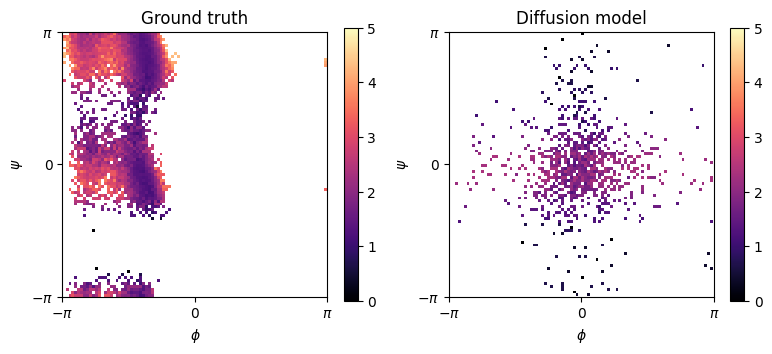

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import math
import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Dihedral

temp = 300
k = 1.99  # cal/(K・mol)
fig = plt.figure(figsize=(8,4))
for i, (topology_path, traj_path) in enumerate(zip(["./ala2_cg.pdb", "./cg_diffusion.pdb"], ["./ala2_cg.xtc", "./cg_diffusion.xtc"])):
  ax = fig.add_subplot(1, 2, i+1)
  u = mda.Universe(topology_path, traj_path)
  R = Dihedral([u.select_atoms("index 0-3"), u.select_atoms("index 1-4")]).run()
  H, xedges, yedges = np.histogram2d(R.angles[:, 0], R.angles[:, 1], bins=(90, 90))
  X, Y = np.meshgrid(np.deg2rad(xedges), np.deg2rad(yedges))
  hist = ax.pcolormesh(X, Y, -1*k * temp * np.log(H / sum(H)).T / 1000, cmap="magma", vmin=0, vmax=5)
  ax.set_xlim(-np.pi, np.pi)
  ax.set_ylim(-np.pi, np.pi)
  ax.set_xlabel(r"$\phi$")
  ax.set_ylabel(r"$\psi$")
  ax.set_xticks([-math.pi, 0, math.pi], [r"$-\pi$", "0", r"$\pi$"])
  ax.set_yticks([-math.pi, 0, math.pi], [r"$-\pi$", "0", r"$\pi$"])
  ax.set_aspect("equal")
  plt.colorbar(hist, ax=ax, shrink=0.75)
  if i == 0:
    ax.set_title("Ground truth")
  elif i == 1:
    ax.set_title("Diffusion model")

plt.tight_layout()